# Subpixel waterbodies <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:**
[ga_ls_wo_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls_wo_3),
[wofs_summary](https://explorer.sandbox.dea.ga.gov.au/wofs_summary),
[DEA Waterbodies](https://www.ga.gov.au/dea/products/dea-waterbodies)

## Description
DEA Waterbodies uses WOfS, a classification of Landsat pixels into wet and dry, to identify and track waterbodies throughout the Australian continent. One limitation is the size of the Landsat pixels, 25 m x 25 m, which can be quite large compared to the size of some waterbodies. Can we identify the maximum extent of a waterbody better than a whole pixel approach, as in e.g. Bishop-Taylor et al. (2019; https://doi.org/10.3390/rs11242984) or Sall et al. (2020; https://doi.org/10.1002/rse2.172)? How would this affect our time series?

This notebook takes an existing DEA Waterbodies polygon, refines it using subpixel extents, and recalculates the time series using the subpixel extents for comparison.

***

## Getting started

Specify the geohash of the polygon you want to refine in the "Configuration" section, and run all cells to do the analysis.

### Load packages

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import shapely
from tqdm.notebook import tqdm
from affine import Affine
from odc.ui import with_ui_cbk

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.spatial import xr_vectorize, subpixel_contours
from dea_tools.waterbodies import get_waterbody


/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Configuration

Specify the geohash of the waterbody to evaluate:

In [2]:
geohash = "r3dn23tun"  # Point Hut Pond

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="Subpixel-waterbodies")

### Load the DEA Waterbodies polygons

We can use `dea_waterbodies.get_waterbody` to get the polygon associated with any waterbody in DEA Waterbodies.

In [4]:
wb = get_waterbody(geohash)

### Load the WOfS summary

The WOfS summary is used to define the waterbody maximum extent.

In [5]:
wofs = dc.load(
    "wofs_summary",
    geopolygon=datacube.utils.geometry.Geometry(
        wb.geometry.iloc[0].buffer(100), crs=wb.crs
    ),
).isel(time=0)

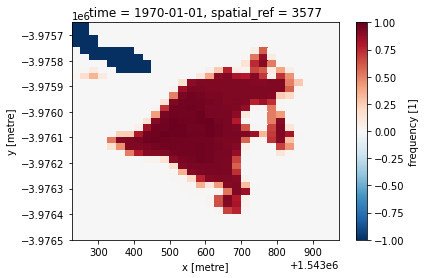

In [6]:
fig, ax = plt.subplots(1, 1)
wofs.frequency.plot(ax=ax)

## Reproduce DEA Waterbodies

Find the 5% and 10% polygons, discard any under 5 px, and then do a spatial join.

In [7]:
pc_10 = xr_vectorize(wofs.frequency >= 0.10, crs=wofs.crs)
pc_05 = xr_vectorize(wofs.frequency >= 0.05, crs=wofs.crs)

pc_10 = pc_10[pc_10.attribute == 1]
pc_05 = pc_05[pc_05.attribute == 1]

# Discard polygons with under 5 px.
pc_05 = pc_05[pc_05.area >= 25 ** 2]
pc_10 = pc_10[pc_10.area >= 25 ** 2]

# Then join.
joined = gpd.sjoin(pc_05, pc_10, lsuffix="05", rsuffix="10", how="right")

# Allow a 5% polygon as long as it intersects with a 10% polygon.
ok_05 = set(joined.index_05)
pc_05 = pc_05.loc[ok_05]

wb_pixels = pc_05.reset_index(drop=True)

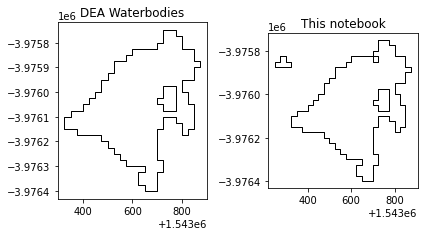

In [8]:
fig, axs = plt.subplots(1, 2)
wb_pixels.plot(ax=axs[1], edgecolor="k", facecolor="None")
wb.plot(ax=axs[0], edgecolor="k", facecolor="None")
axs[0].set_title("DEA Waterbodies")
axs[1].set_title("This notebook")
plt.tight_layout()

## Subpixel extent

Using `subpixel_contours`, find the subpixel extents of the waterbody. We can set the contour levels to 5% and 10% as above, but we can also change them to other values. This modifies the eventual error in the boundary quite dramatically for steep-edged lakes.

In [9]:
contours = subpixel_contours(wofs.frequency, z_values=[0.05, 0.10]).set_index(
    "z_value", drop=True
)

pc_05 = gpd.GeoDataFrame(
    geometry=[shapely.geometry.Polygon(ls) for ls in contours.iloc[0].geometry]
)
pc_10 = gpd.GeoDataFrame(
    geometry=[shapely.geometry.Polygon(ls) for ls in contours.iloc[1].geometry]
)

# Determine whether each polygon is an "inner" polygon or not.
pc_10_agg = pc_10.geometry[0]
for g in pc_10.geometry[1:]:
    pc_10_agg = pc_10_agg.symmetric_difference(g)

pc_05_agg = pc_05.geometry[0]
for g in pc_05.geometry[1:]:
    pc_05_agg = pc_05_agg.symmetric_difference(g)

pc_05 = gpd.GeoDataFrame(geometry=list(pc_05_agg))
pc_10 = gpd.GeoDataFrame(geometry=list(pc_10_agg))

# Discard anything under 5 px.
pc_05 = pc_05[pc_05.area >= 25 ** 2]
pc_10 = pc_10[pc_10.area >= 25 ** 2]

# Spatial join to find 5% extents for 10% polygons.
joined = gpd.sjoin(pc_05, pc_10, lsuffix="05", rsuffix="10", how="right")
pc_05 = pc_05.loc[joined.index_05]

wb_subpixel = pc_05.set_crs("EPSG:3577")

Combine both sets with a spatial join.

In [10]:
wb_joined = gpd.sjoin(wb_pixels, wb_subpixel, how="left")
# Buffer to fix bad geometry.
wb_joined.geometry = wb_joined.geometry.buffer(0)

In [11]:
# Add the geometry back in.
wb_joined = wb_joined.join(wb_pixels, rsuffix="_pixel").join(
    wb_subpixel, on="index_right", rsuffix="_subpixel"
)

Finally, filter to only include the polygon that maximally overlaps with the DEA Waterbodies polygon.

In [12]:
biggest_overlap = np.argmax(
    [wb.geometry[0].intersection(g).area for g in wb_joined.geometry_pixel]
)

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 1543700 -3975825 at 1543700 -3975825


TopologicalError: The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7f552a7e09a0>

In [ ]:
wb_joined = gpd.GeoDataFrame([wb_joined.iloc[biggest_overlap]])

## Shape comparison

Let's look at the shape of the waterbody.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoDataFrame(geometry=wb_joined.geometry_pixel).plot(
    ax=ax, edgecolor="blue", facecolor="None"
)
gpd.GeoDataFrame(geometry=wb_joined.geometry_subpixel).plot(
    ax=ax, edgecolor="red", facecolor="None"
)

### Exporting the subpixel polygon

We can export the subpixel polygon as a GeoJSON file for later review, e.g. for loading into QGIS.

In [13]:
gpd.GeoDataFrame(geometry=wb_joined.geometry_subpixel, crs="EPSG:3577").to_file(
    f"{geohash}_subpixel.geojson", driver="GeoJSON"
)

## Extracting time series

Now we will generate a surface area time series using both extents.

### Load WOfS

Load WOfS for all available times from 2015 to 2020.

In [14]:
wofs_daily = dc.load(
    "ga_ls_wo_3",
    geopolygon=datacube.utils.geometry.Geometry(
        wb.geometry.iloc[0].buffer(100), crs=wb.crs
    ),
    progress_cbk=with_ui_cbk(),
    time=("2015-01", "2020-01"),
    output_crs='EPSG:3577',
    resolution=(-25, 25),
    resampling='nearest',
)

### Rasterise the waterbodies

Rasterise the pixel and subpixel waterbodies. To rasterise the subpixel waterbodies while maintaining their subpixel nature, we'll use a [prototype of a partial-pixel rasterising algorithm](https://gist.github.com/perrygeo/721040f8545272832a42#file-rasterize-py) that was suggested to be added to rasterio, but wasn't ever added.

In [15]:
def _rasterize_geom(geom, shape, affinetrans, all_touched):
    from rasterio import features

    indata = [(geom, 1)]
    rv_array = features.rasterize(
        indata, out_shape=shape, transform=affinetrans, fill=0, all_touched=all_touched
    )
    return rv_array


def rasterize_pctcover(geom, atrans, shape):
    import rasterio
    import fiona
    import numpy as np
    from shapely.geometry import box

    alltouched = _rasterize_geom(geom, shape, atrans, all_touched=True)
    exterior = _rasterize_geom(geom.exterior, shape, atrans, all_touched=True)

    # Create percent cover grid as the difference between them
    # at this point all cells are known 100% coverage,
    # we'll update this array for exterior points
    pctcover = 100 * (alltouched - exterior)

    # loop through indicies of all exterior cells
    for r, c in zip(*np.where(exterior == 1)):

        # Find cell bounds, from rasterio DatasetReader.window_bounds
        window = ((r, r + 1), (c, c + 1))
        ((row_min, row_max), (col_min, col_max)) = window
        x_min, y_min = atrans * (col_min, row_max)
        x_max, y_max = atrans * (col_max, row_min)
        bounds = (x_min, y_min, x_max, y_max)

        # Construct shapely geometry of cell
        cell = box(*bounds)

        # Intersect with original shape
        cell_overlap = cell.intersection(geom)

        # update pctcover with percentage based on area proportion
        coverage = cell_overlap.area / cell.area
        pctcover[r, c] = int(coverage * 100)

    return pctcover

In [16]:
raster_pixel = (
    rasterize_pctcover(
        wb_joined.iloc[0].geometry_pixel, wofs.geobox.transform, wofs.frequency.shape
    )
    / 100
)
raster_subpixel = (
    rasterize_pctcover(
        wb_joined.iloc[0].geometry_subpixel, wofs.geobox.transform, wofs.frequency.shape
    )
    / 100
)

### Count wet pixels

For each WOfS observation, multiply the wet pixel mask by the raster mask and sum the result to obtain the wet surface area.

In [17]:
px_wet_pixel = ((wofs_daily == 128) * raster_pixel).sum(axis=(1, 2)).water
px_wet_subpixel = ((wofs_daily == 128) * raster_subpixel).sum(axis=(1, 2)).water

Invalid days are those with >10% missing observations.

In [18]:
missing = (wofs_daily != 128) & (wofs_daily != 0)

In [19]:
px_missing_pixel = (missing * raster_pixel).sum(axis=(1, 2)).water
px_missing_subpixel = (missing * raster_subpixel).sum(axis=(1, 2)).water

In [20]:
invalid_pixel = px_missing_pixel > 0.1 * raster_pixel.sum()
invalid_subpixel = px_missing_subpixel > 0.1 * raster_subpixel.sum()

### Plot the time series

In [21]:
time_series = pd.DataFrame(
    {
        "pixel": px_wet_pixel,
        "subpixel": px_wet_subpixel,
        "invalid_pixel": invalid_pixel,
        "invalid_subpixel": invalid_subpixel,
    },
    index=pd.DatetimeIndex(wofs_daily.time.values),
)

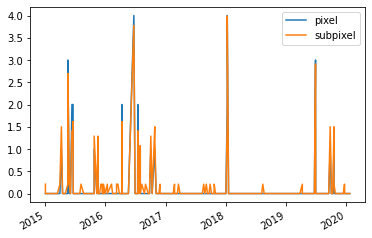

In [22]:
time_series.pixel[~time_series.invalid_pixel].plot(legend=True)
time_series.subpixel[~time_series.invalid_subpixel].plot(legend=True)

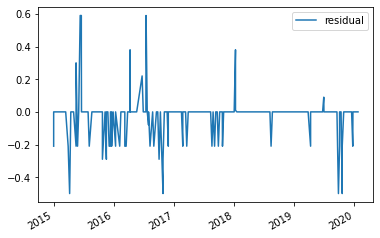

In [23]:
(time_series.pixel - time_series.subpixel)[
    ~(time_series.invalid_pixel | time_series.invalid_subpixel)
].plot(label="residual", legend=True)

Of course, there is not much difference in the time series for any waterbody of more than a few pixels.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2021

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)